# Superhero and Supervillain Name Generator

### Importing Libraries

In [41]:
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPool1D, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
print("Tensorflow version:",tf.__version__)

Tensorflow version: 2.4.0


In [3]:
with open("./superheroes.txt", "r") as file:
    data = file.read()
    
data[:100]

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

### Converting between Names and Sequences

In [4]:
tokenizer = Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [5]:
tokenizer.fit_on_texts(data)

In [6]:
# Help convert characters to numbers and vice versa

char_to_index = tokenizer.word_index
index_to_char = dict((v, k) for k, v in char_to_index.items())

In [7]:
print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


In [8]:
names = data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [9]:
def name_to_seq(name):
    return [tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [10]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [11]:
def seq_to_name(seq):
    return "".join([index_to_char[i] for i in seq if i!=0])

In [12]:
seq_to_name([25, 16, 12, 20, 2, 1])

'jumpa\t'

### Creating Sequences and Adding Padding

In [13]:
# creating sequences
sequences = []

for name in names:
    seq = name_to_seq(name)
    if len(seq) >= 2:
        sequences += [seq[:i] for i in range(2, len(seq)+1)]

In [14]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [15]:
# add padding

max_len = max(len(x) for x in sequences)
print(max_len)

33


In [16]:
padded_sequences = pad_sequences(
    sequences,
    padding="pre",
    maxlen=max_len
)

In [17]:
padded_sequences[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 25, 16])

In [18]:
padded_sequences.shape

(88279, 33)

### Creating Train and Validation Set

In [19]:
x, y = padded_sequences[:, :-1], padded_sequences[:,-1]
print(x.shape, y.shape)

(88279, 32) (88279,)


In [34]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [35]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(79451, 32) (79451,)
(8828, 32) (8828,)


In [36]:
# including zero
num_chars = len(char_to_index.keys()) + 1

### Building the model

In [39]:
model= Sequential([
    Embedding(num_chars, 8, input_length=max_len-1),
    Conv1D(64, 5, strides=1, activation='tanh', padding='causal'),
    MaxPool1D(2),
    Bidirectional(LSTM(32)),
    Dropout(0.2),
    Dense(num_chars, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer="adam",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 32, 8)             232       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            2624      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                24832     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 29)                1885      
Total params: 29,573
Trainable params: 29,573
Non-trainable params: 0
__________________________________________________

### Training the model

In [40]:
ES = EarlyStopping(monitor='val_accuracy', patience=4)

histry = model.fit(
            X_train, y_train,
            validation_split=0.25,
            epochs=50,
            callbacks=[ES],
            verbose=1
        )

Epoch 1/50
1863/1863 [==============================] - 18s 8ms/step - loss: 2.9306 - accuracy: 0.1488 - val_loss: 2.6205 - val_accuracy: 0.2166
Epoch 2/50
1863/1863 [==============================] - 14s 8ms/step - loss: 2.6161 - accuracy: 0.2152 - val_loss: 2.5412 - val_accuracy: 0.2310
Epoch 3/50
1863/1863 [==============================] - 16s 9ms/step - loss: 2.5436 - accuracy: 0.2361 - val_loss: 2.4891 - val_accuracy: 0.2471
Epoch 4/50
1863/1863 [==============================] - 18s 10ms/step - loss: 2.4960 - accuracy: 0.2471 - val_loss: 2.4468 - val_accuracy: 0.2582
Epoch 5/50
1863/1863 [==============================] - 18s 10ms/step - loss: 2.4633 - accuracy: 0.2562 - val_loss: 2.4197 - val_accuracy: 0.2640
Epoch 6/50
1863/1863 [==============================] - 20s 11ms/step - loss: 2.4361 - accuracy: 0.2631 - val_loss: 2.4010 - val_accuracy: 0.2717
Epoch 7/50
1863/1863 [==============================] - 21s 11ms/step - loss: 2.4044 - accuracy: 0.2706 - val_loss: 2.3796 - va

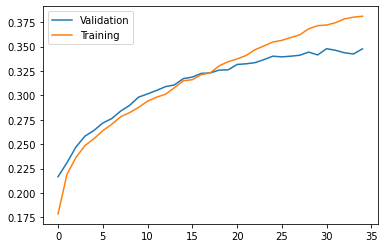

In [43]:
epocs_ran = len(histry.history['loss'])

plt.plot(range(epocs_ran), histry.history['val_accuracy'], label='Validation')
plt.plot(range(epocs_ran), histry.history['accuracy'], label='Training')

plt.legend()
plt.show()

### Generate Names

In [50]:
def generate_names(seed):
    for i in range(0, 40):
        seq = name_to_seq(seed)
        padded = pad_sequences([seq], padding="pre", maxlen=max_len-1, truncating='pre')
        
        pred = model.predict(padded)[0]
        pred_char = index_to_char[tf.argmax(pred).numpy()]
        seed += pred_char
        
        if pred_char == '\t':
            break
        
    print(seed)

In [62]:
generate_names('dar')

dark saros	


In [61]:
generate_names('lo')

lona datker	


In [58]:
generate_names('lee')

leen gara	
